In [1]:
import os
import math
import time
import random
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [2]:
# custom imports
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'utils')))

## Open randomly a many-particle file

In [3]:
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n25-0.5to10GeV-0.5eta')

hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])

dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
       for file in hit_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

In [4]:
random.seed(146)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
df

Event chosen: event000000017-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index
0,4503599694479360,936748859932016665,31.379339,9.399736,-1.676870,0.109469,3.038106,0.920322,-0.162503,3.180354,0,0,0,0,0
1,4503600030023680,936748859932016693,-12.503651,-29.684799,-0.171122,0.107451,-3.691969,-8.789945,-0.050649,9.534542,0,0,0,0,0
2,4503600046800896,936748859932016694,-11.310235,-30.018560,9.881972,0.112010,-1.245754,-3.333640,1.096305,3.725333,0,0,0,0,0
3,4503599962914816,936748859932016708,4.243962,-31.675226,12.146327,0.114051,1.012109,-7.481826,2.869504,8.077580,0,0,0,0,0
4,4503599744811008,936748859932016736,24.096832,-21.055742,15.597966,0.119863,0.527122,-0.447858,0.337144,0.776700,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,4503599744811008,1657324937750252637,972.107300,-277.867828,510.115875,3.920007,0.681103,0.120555,0.337144,0.776700,0,0,0,0,12
345,4503599744811008,1657324937750252638,979.805237,-276.478363,513.928650,3.949307,0.680269,0.125170,0.337144,0.776700,0,0,0,0,13
346,4503599761588224,1657324937750252638,977.517090,-282.114990,515.799194,3.806517,6.188352,-1.468520,3.223208,7.131093,0,0,0,0,10
347,4503599946137600,1657324937750252795,769.509277,665.979858,20.197447,3.396190,6.523401,6.049232,0.176530,8.898893,0,0,0,0,10


## Let's try the algorithm in the x-y plane

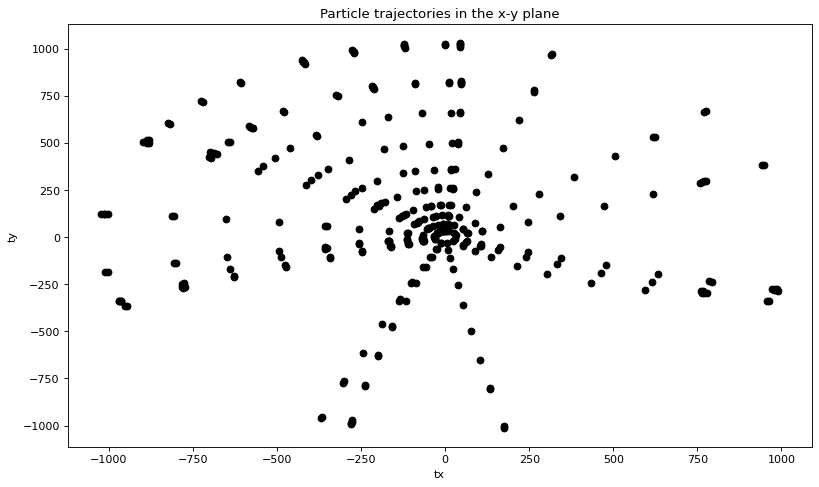

In [5]:
# get every particle
unique_particle_ids = list(set(df['particle_id']))
plt.figure(figsize=(12, 7), dpi=80)

# plot its track
for idx, pid in enumerate(unique_particle_ids):
    particle_df = df[df['particle_id'] == pid]
    plt.scatter(x=particle_df['tx'], y=particle_df['ty'], color='k')

plt.xlabel('tx')
plt.ylabel('ty')
plt.title('Particle trajectories in the x-y plane')
plt.show()

Functions to compute circles.

In [6]:
def minor(arr, i, j):
    """ Removes the ith row and jth column of an array. """
    return arr[np.array(list(range(i)) + list(range(i + 1, arr.shape[0])))[:, np.newaxis],
               np.array(list(range(j)) + list(range(j + 1, arr.shape[1])))]


def compute_circle(p1, p2, p3):
    """ Given 3 points in the x-y plane it returns the circle (center & radius) defined by them. """
    A = np.array([
        [0, 0, 0, 1],
        [p1[0] ** 2 + p1[1] ** 2, p1[0], p1[1], 1],
        [p2[0] ** 2 + p2[1] ** 2, p2[0], p2[1], 1],
        [p3[0] ** 2 + p3[1] ** 2, p3[0], p3[1], 1],
    ])

    x_0 = (1 / 2) * np.linalg.det(minor(A, 0, 1)) / np.linalg.det(minor(A, 0, 0))
    y_0 = (-1 / 2) * np.linalg.det(minor(A, 0, 2)) / np.linalg.det(minor(A, 0, 0))
    r = np.sqrt(x_0 ** 2 + y_0 ** 2 + np.linalg.det(minor(A, 0, 3)) / np.linalg.det(minor(A, 0, 0)))

    return (x_0, y_0), r

Preprocessing.

In [7]:
def preprocess(df):
    """ Preprocesses a dataframe and return useful dictionaries. """
    xy_point_to_pid = {}
    xy_point_to_row = {}
    for row, series in df.iterrows():
        xy_point = (series['tx'], series['ty'])
        xy_point_to_pid[xy_point] = series['particle_id']
        xy_point_to_row[xy_point] = row
    return xy_point_to_pid, xy_point_to_row

Function to assess the fitting of circles.

In [8]:
def point_to_circle_distance(p, x_0, y_0, r):
    """ Returns the distance of a point to a circle. """
    return np.abs(np.sqrt(np.square(p[0] - x_0) + np.square(p[1] - y_0)) - r)


def get_inliers(x_0, y_0, r, points, threshold=1e-2):
    """ Returns a list with the inliers that a specific circle has. """
    inliers = []
    for p in points:
        if point_to_circle_distance(p, x_0, y_0, r) < threshold:
            inliers.append(p)
    return inliers

Circle ransac main function.

In [9]:
print(f'The truth-number of particles is {len(unique_particle_ids)}')

The truth-number of particles is 24


In [10]:
def circle_ransac(df, num_iterations=1000):
    """ Performs the circle-ransac algorithm for a given number of iterations. """
    df_copy = df.copy()
    xy_point_to_pid, xy_point_to_row = preprocess(df_copy)
    xy_points = list(xy_point_to_pid)

    # iterate for a specific amount of times
    particles_found = set()
    for _ in tqdm(range(num_iterations)):

        if len(xy_points) < 3:
            break
        
        # sample randomly 3 hits from the available ones
        p1, p2, p3 = random.sample(xy_points, k=3)
        # compute the circle they uniquely define
        center, r = compute_circle(p1, p2, p3)
        x_0, y_0 = center
        
        # get the inliers (i.e. hits belonging in the same circle)
        inliers = get_inliers(x_0, y_0, r, xy_points)
        
        # if at least 10 inliers have been found
        if len(inliers) >= 10:
            
            # voting dictionary used ONLY for evaluation
            votes = {}
            # print(f'Found {len(inliers)} inliers!')
            
            # for every hit
            for inlier in inliers:

                pid = xy_point_to_pid[inlier]
                row = xy_point_to_row[inlier]
                
                # print(f'\t{pid}')
                
                # vote the particle it belongs to, ONLY for evaluation
                votes[pid] = votes.get(pid, 0) + 1
                # remove it from the dataframe as it has been found that it already belongs to a track
                df_copy.drop(row, inplace=True)

            # compute the leading particle and add it to the set
            leading_particle = max(votes, key=votes.get)
            particles_found.add(leading_particle)

            # recompute useful mappings
            xy_point_to_pid, xy_point_to_row = preprocess(df_copy)
            xy_points = list(xy_point_to_pid)

    print(f'Number of distinct particles found: {len(particles_found)}, out of {len(unique_particle_ids)}')
        
        
circle_ransac(df, num_iterations=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Number of distinct particles found: 24, out of 24


## Let's try the algorithm in the r-z plane

In [11]:
random.seed(1746)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
df

Event chosen: event000000029-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index
0,4503599845474304,936748859932016651,33.060692,-7.245751,2.705407,0.113265,8.064406,-1.757049,0.659745,8.280598,0,0,0,0,1
1,4503599795142656,936748859932016665,30.396164,11.146264,-12.347930,0.115639,2.906349,1.076095,-1.182017,3.318610,0,0,0,0,0
2,4503599929360384,936748859932016665,28.925173,13.759413,-7.203018,0.109554,3.361872,1.609842,-0.838211,3.821981,0,0,0,0,0
3,4503599694479360,936748859932016666,27.892696,15.593581,12.488790,0.114510,2.516363,1.417763,1.128784,3.102813,0,0,0,0,0
4,4503599761588224,936748859932016666,26.319122,18.388945,8.997042,0.111642,0.955239,0.679159,0.328435,1.221791,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,4503599744811008,1657324937750252454,817.119263,-612.434509,-136.978043,3.464485,1.453612,-0.706911,-0.215513,1.634111,0,0,0,0,14
348,4503599845474304,1657324937750252671,996.984192,-181.591736,81.022644,3.392119,8.168941,-1.179095,0.659745,8.280598,0,0,0,0,13
349,4503599845474304,1657324937750252672,1003.615540,-182.547256,81.558197,3.414541,8.169515,-1.175119,0.659745,8.280598,0,0,0,0,14
350,4503599694479360,1657324937750252761,830.228577,582.645935,397.131042,3.641313,2.176367,1.898832,1.128784,3.102813,0,0,0,0,11


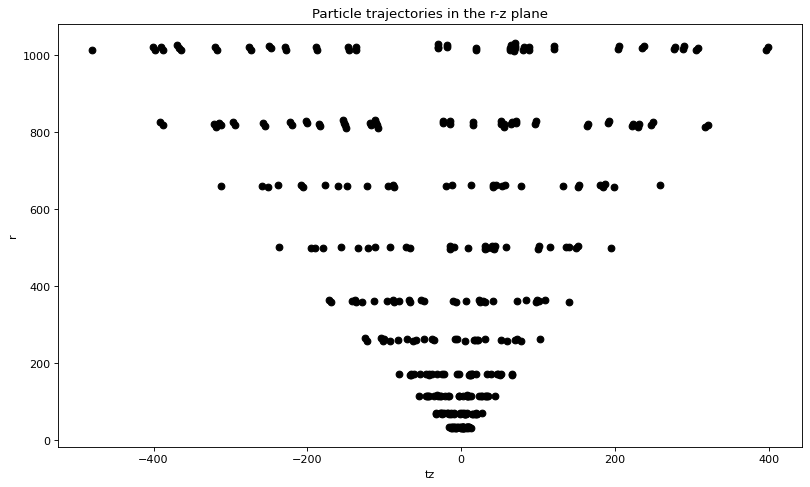

In [12]:
# get every particle
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
unique_particle_ids = list(set(df['particle_id']))
plt.figure(figsize=(12, 7), dpi=80)

# plot its track
for idx, pid in enumerate(unique_particle_ids):
    particle_df = df[df['particle_id'] == pid]
    plt.scatter(x=particle_df['tz'], y=particle_df['r'], color='k')

plt.xlabel('tz')
plt.ylabel('r')
plt.title('Particle trajectories in the r-z plane')
plt.show()

Function to compute straight lines.

In [13]:
def compute_line(p1, p2):
    """ Given 2 points in the x-y plane it returns the line (slone & intercept) they belong to. """
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    b = p1[1] - m * p1[0]
    return m, b

Preprocessing.

In [14]:
def preprocess_2(df):
    """ Preprocesses a dataframe and return useful dictionaries. """
    zr_point_to_pid = {}
    zr_point_to_row = {}
    for row, series in df.iterrows():
        zr_point = (series['tz'], series['r'])
        zr_point_to_pid[zr_point] = series['particle_id']
        zr_point_to_row[zr_point] = row
    return zr_point_to_pid, zr_point_to_row

Function to assess the fitting of lines.

In [15]:
def point_to_line_distance(p, m, b):
    """ Returns the distance of a point to a line. """
    return np.abs(-m * p[0] + 1 * p[1] - b) / np.sqrt(np.square(-m) + np.square(1))


def get_inliers_2(m, b, points, threshold=8e-2):
    """ Returns a list with the inliers that a specific line has. """
    inliers = []
    for p in points:
        if point_to_line_distance(p, m, b) < threshold:
            inliers.append(p)
    return inliers

Line ransac main function.

In [16]:
print(f'The truth-number of particles is {len(unique_particle_ids)}')

The truth-number of particles is 25


In [17]:
def line_ransac(df, num_iterations=1000):
    """ Performs the line-ransac algorithm for a given number of iterations. """
    df_copy = df.copy()
    zr_point_to_pid, zr_point_to_row = preprocess_2(df_copy)
    zr_points = list(zr_point_to_pid)

    # iterate for a specific amount of times
    particles_found = set()
    for _ in tqdm(range(num_iterations)):

        if len(zr_points) < 2:
            break
        
        # sample randomly 2 hits from the available ones
        p1, p2 = random.sample(zr_points, k=2)
        # compute the line they uniquely define
        m, b = compute_line(p1, p2)
        
        # get the inliers (i.e. hits belonging in the same line)
        inliers = get_inliers_2(m, b, zr_points)
        
        # if at least 10 inliers have been found
        if len(inliers) >= 10:
            
            # voting dictionary used ONLY for evaluation
            votes = {}
            # print(f'Found {len(inliers)} inliers!')
            
            # for every hit
            for inlier in inliers:

                pid = zr_point_to_pid[inlier]
                row = zr_point_to_row[inlier]
                
                # print(f'\t{pid}')
                
                # vote the particle it belongs to, ONLY for evaluation
                votes[pid] = votes.get(pid, 0) + 1
                # remove it from the dataframe as it has been found that it already belongs to a track
                df_copy.drop(row, inplace=True)

            # compute the leading particle and add it to the set
            leading_particle = max(votes, key=votes.get)
            particles_found.add(leading_particle)

            # recompute useful mappings
            zr_point_to_pid, zr_point_to_row = preprocess_2(df_copy)
            zr_points = list(zr_point_to_pid)

    print(f'Number of distinct particles found: {len(particles_found)}, out of {len(unique_particle_ids)}')
        
        
line_ransac(df, num_iterations=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

Number of distinct particles found: 21, out of 25
